In [ ]:
!git clone --recursive https://github.com/bemc22/GeneralizedR2R
%cd GeneralizedR2R
!pip install ./deepinv/

In [ ]:
r"""
Self-supervised learning with Generalized Recorrupted-to-Recovered (GR2R)

Poisson Denoising Example
====================================================================================================

This example shows you how to train a reconstruction network for an denoising problem on a fully self-supervised way, i.e., using corrupted measurement data only.
"""

import os
import deepinv as dinv
from torch.utils.data import DataLoader
import torchvision
import torch
import numpy as np
from pathlib import Path
from torchvision import transforms
from deepinv.optim.prior import PnP
from deepinv.utils.demo import load_dataset, load_degradation
import wandb
import argparse
from torch.utils.data import DataLoader, random_split
from deepinv.loss import PSNR, SSIM, Loss, SupLoss
import matplotlib.pyplot as plt



/home/bemc/miniconda3/envs/deepinv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:datasets:PyTorch version 2.1.1 available.


In [ ]:
def get_weights_url(file_name):
    return (
        "https://huggingface.co/bemc22/"
        + "GeneralizedR2R"
        + "/resolve/main/"
        + file_name
        + "?download=true"
    )

In [ ]:
# ---------------------------------------------------------------
# Setup paths for data loading and results.
# ---------------------------------------------------------------

BASE_DIR = Path(".")
# PROJECT_NAME = "denoising-poisson-exp-newloss"
PROJECT_NAME = "denoising-poisson"
ORIGINAL_DATA_DIR =  Path("./data")
DATA_DIR = ORIGINAL_DATA_DIR / "measurements"
RESULTS_DIR = BASE_DIR / "results"
DEG_DIR = BASE_DIR / "degradations"
CKPT_DIR = BASE_DIR / "ckpts" / PROJECT_NAME

# Set the global random seed from pytorch to ensure reproducibility of the example.
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"


Selected GPU 0 with 23733 MiB free memory 


In [ ]:
def run(args, batch_id=0, weights_id=0):
    # print  all the arguments
    print(args)

    trial_id = args.trial
    torch.manual_seed(trial_id)

    run_name = f"{args.loss}-{args.noise}"

    wandb_setup = {
        "project": PROJECT_NAME,
        "config": args,
        "name": run_name,
    }

    operation = f"Denoising_{args.noise}"
    train_dataset_name = "div2k"
    # # ----------------------------------------------------------------------------------
    # Generate a dataset of images and load it.
    # ----------------------------------------------------------------------------------
    noise_model = dinv.physics.PoissonNoise(args.noise)
    noise_model.sigma = args.noise
    physics = dinv.physics.Denoising(noise_model=noise_model)

    # Use parallel dataloader if using a GPU to fasten training,
    # otherwise, as all computes are on CPU, use synchronous data loading.
    num_workers = 0 if torch.cuda.is_available() else 0
    n_images_max = 100

    my_dataset_name = "div2k_poisson"
    measurement_dir = DATA_DIR / train_dataset_name / operation

    # check if the dataset is already generated
    # if not, generate it
    if not os.path.exists(measurement_dir / f"{my_dataset_name}0.h5"):

        img_size = 224
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomCrop((img_size, img_size))
            ])

        test_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.CenterCrop((512, 512))
        ])

        train_dataset    =  dinv.datasets.DIV2K(root=ORIGINAL_DATA_DIR, mode="train", transform=transform, download=True)
        test_dataset     =  dinv.datasets.DIV2K(root=ORIGINAL_DATA_DIR, mode="val", transform=test_transform, download=True)

        deepinv_datasets_path = dinv.datasets.generate_dataset(
            train_dataset=train_dataset,
            test_dataset=test_dataset,
            physics=physics,
            device=device,
            save_dir=measurement_dir,
            train_datapoints=n_images_max,
            num_workers=num_workers,
            dataset_filename=str(my_dataset_name),
        )

    else:
        deepinv_datasets_path = measurement_dir / f"{my_dataset_name}0.h5"

    train_dataset = dinv.datasets.HDF5Dataset(path=deepinv_datasets_path, train=True)
    test_dataset = dinv.datasets.HDF5Dataset(path=deepinv_datasets_path, train=False)


    # Set up the reconstruction network
    # ---------------------------------------------------------------

    n_channels = 3

    model = dinv.models.ArtifactRemoval( dinv.models.DRUNet( in_channels=n_channels,
                            out_channels=n_channels,
                            pretrained=None,
                            nc=[16, 32, 64, 128]
                            ).to(device)
    )

    # print number of parameters
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")


    # Set up the training parameters
    # --------------------------------------------
    noise_level   = args.noise


    if args.loss == "sup":   # SUPERVISED LOSS
        loss = dinv.loss.SupLoss()

    if args.loss == "neigh": # GENERALIZED R2R LOSS - NLL VARIANT

        neigh_loss = dinv.loss.Neighbor2Neighbor()
        loss = [ neigh_loss ]

    elif args.loss == "gr2r_mse": # GENERALIZED R2R LOSS - MSE VARIANT


        r2r_loss = dinv.loss.R2RLoss(noise_model=noise_model)
        loss     = [ r2r_loss ]
        model    = r2r_loss.adapt_model(model)

    test_dataloader = DataLoader(
        test_dataset, batch_size=1, num_workers=num_workers, shuffle=False
    )


    filename = f"artifact_r2r_poisson.pth"
    url = get_weights_url(file_name=filename)
    ckpt = torch.hub.load_state_dict_from_url(
                    url, map_location=lambda storage, loc: storage, file_name=filename
                )

    model.load_state_dict(ckpt["state_dict"])

    model.eval()

    logs = {}

    x, y = test_dataset[batch_id]

    x = x.unsqueeze(0).to(device)
    y = y.unsqueeze(0).to(device)

    x_net = model(y, physics)

    psnr_val = PSNR()(x=x, x_net=x_net, y=y, physics=physics).item()
    ssim_val = SSIM()(x=x, x_net=x_net, y=y, physics=physics).item()

    logs["x_est"] = x_net
    logs["psnr"] = psnr_val
    logs["ssim"] = ssim_val

    print(args.loss, args.noise, logs["psnr"], logs["ssim"])

    return logs, x, y


In [ ]:
class Args:
    loss        = "gr2r_mse"
    noise       = 0.1
    trial       = 0
    alpha       = 0.2

args = Args()

Number of parameters: 2040816


/home/bemc/miniconda3/envs/deepinv/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


gr2r_mse 0.1 30.387981414794922 0.8041927218437195


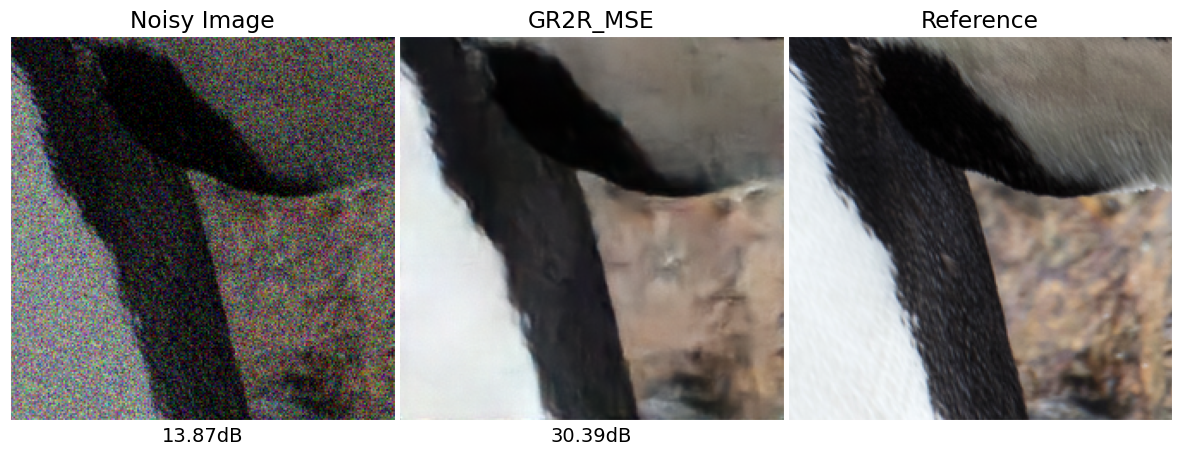

Number of parameters: 2040816
gr2r_mse 0.1 29.21744155883789 0.7806675434112549


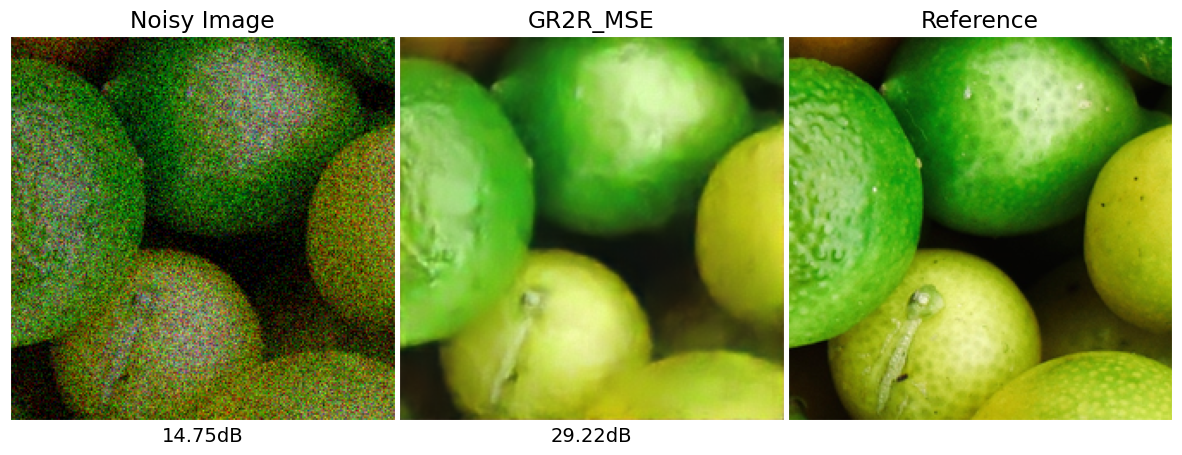

Number of parameters: 2040816
gr2r_mse 0.1 29.300128936767578 0.8265794515609741


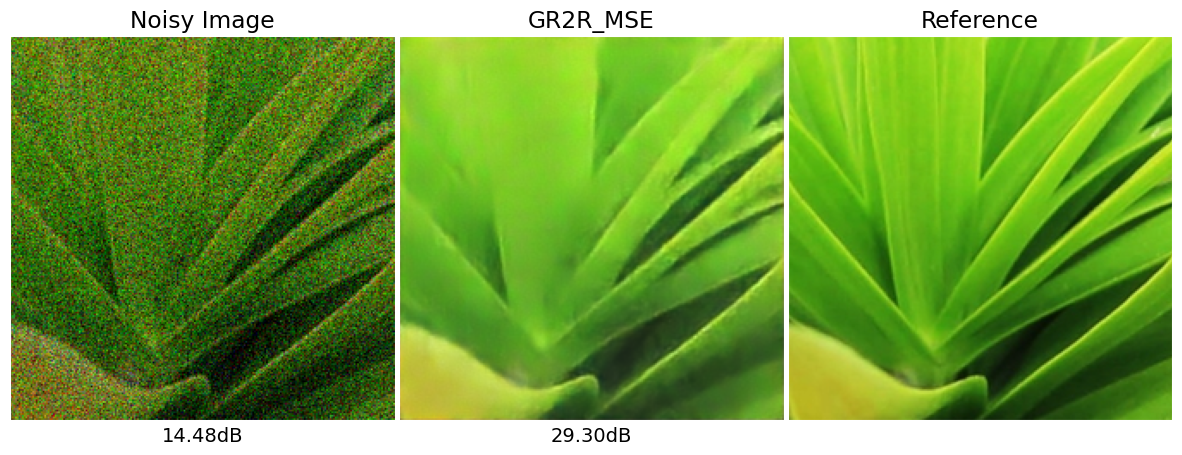

Number of parameters: 2040816
gr2r_mse 0.1 26.4671688079834 0.7531459331512451


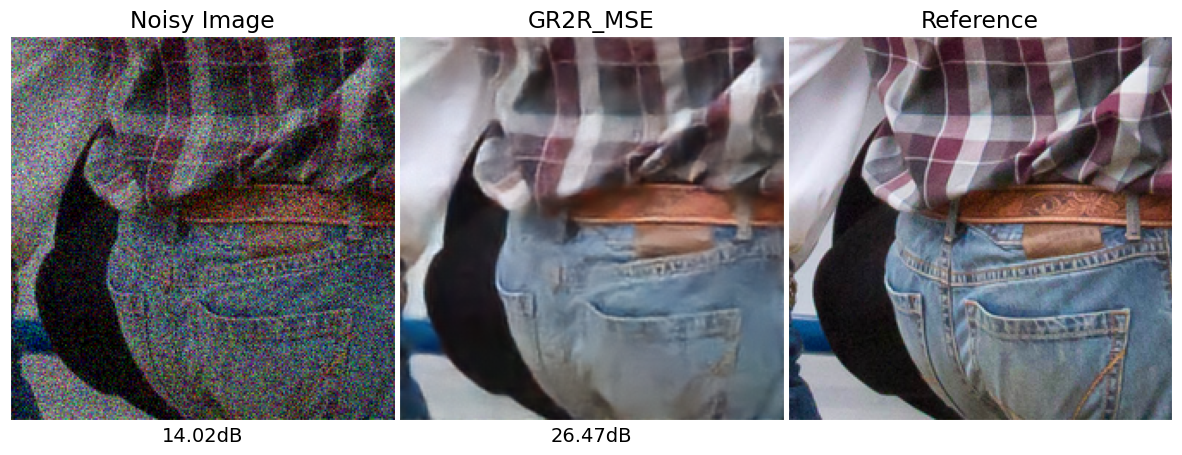

Number of parameters: 2040816
gr2r_mse 0.1 26.466861724853516 0.5559805035591125


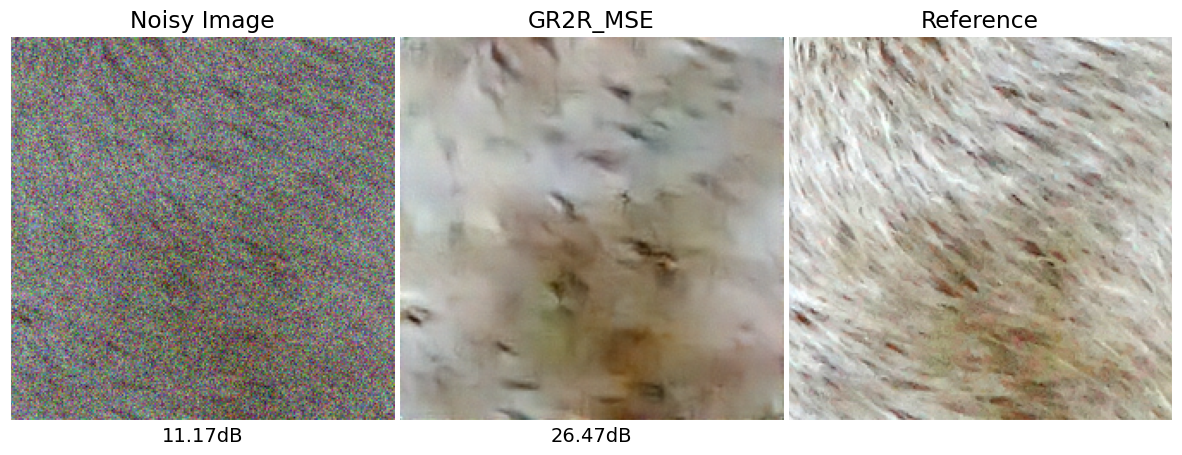

In [ ]:
for kk in range(5):
    batch_id = kk
    loss = [
        ["gr2r_mse", -1],
    ]


    plt.rcParams['text.usetex'] = False
    plt.rcParams.update({'font.size': 14})

    fig, ax = plt.subplots(1, len(loss) + 2, figsize=(15, 5))

    plot_title = True

    for j, l in enumerate(loss):
        loss_name =  l[0]
        args.loss = loss_name
        logs, x, y = run(args, batch_id, l[1])

        x_est = logs["x_est"].cpu().detach().numpy().squeeze()
        x_est = x_est.transpose(1, 2, 0)

        x_est = (x_est - x_est.min()) / (x_est.max() - x_est.min())
        x_est = x_est[::-1, ...]

        ax[j+1].imshow(x_est, origin="lower")


        ax[j+1].set_xlabel(f"{logs['psnr']:.2f}dB", c="black")
        if plot_title:
            ax[j+1].set_title(f"{loss_name.upper()}")
        ax[j+1].set_xticks([])
        ax[j+1].set_yticks([])

        # set image border in white
        for spine in ax[j+1].spines.values():
            spine.set_edgecolor('white')

    x_plot = x.squeeze().cpu().detach().numpy().transpose(1, 2, 0)
    x_plot = (x_plot - x_plot.min()) / (x_plot.max() - x_plot.min())
    x_plot = x_plot[::-1, ...]

    ax[-1].imshow(x_plot, origin="lower")

    if plot_title:
        ax[-1].set_title("Reference")
    ax[-1].set_xticks([])
    ax[-1].set_yticks([])

    for spine in ax[-1].spines.values():
        spine.set_edgecolor('white')

    y_plot = y.squeeze().cpu().detach().numpy().transpose(1, 2, 0)
    y_plot = np.log(1 + y_plot)
    y_plot = (y_plot - y_plot.min()) / (y_plot.max() - y_plot.min())

    y_plot = y_plot[::-1, ...]
    ax[0].imshow(y_plot, origin="lower")


    psnr_baseline = PSNR()(x=x, x_net=y).item()

    if plot_title:
        ax[0].set_title("Noisy Image")
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_xlabel(f"{psnr_baseline:.2f}dB", c="black")

    for spine in ax[0].spines.values():
        spine.set_edgecolor('white')

    # reduce space between subplots
    plt.subplots_adjust(wspace=0.01, hspace=0.1)
    plt.show()
